In [28]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=1785756406 seed_offset=0 real_seed=1785756406
core.init.random: RandomGenerator

In [29]:
import math
import random
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.id import *

In [30]:
def within_360(ang):
    
    return ang - 360.0*int(ang/360.0)

In [31]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [32]:
def initialize_pose(seq1, seq2):
    
    n_residues = len(seq1) + len(seq2)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq1, seq2)
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
    
        dof_dict.update({6*ii:TorsionID(ii+2, BB, 1), 6*ii+1:TorsionID(ii+2, BB, 2), 6*ii+2:TorsionID(ii+2, BB, 3),
                 6*ii+3:TorsionID(ii+1, BB, 5), 6*ii+4:TorsionID(ii+1, BB, 6)})
        
        if seq2 and ii == (n_residues/2) - 1:
            
            continue
        
        movemap.set(TorsionID(ii+2, BB, 1), True)
        movemap.set(TorsionID(ii+2, BB, 2), True)
        movemap.set(TorsionID(ii+2, BB, 3), True)
        movemap.set(TorsionID(ii+1, BB, 5), True)
        movemap.set(TorsionID(ii+1, BB, 6), True)
        
    for ii in range(n_residues-1):
        
        dof_dict.update({6*ii+5:TorsionID(ii+1, CHI, 1)})
        
    dof_dict.update({6*(n_residues-1):TorsionID(n_residues, CHI, 1)})
    
    movemap.set_chi(True)
        
        
        
    return pose, movemap, dof_dict

In [33]:
def find_minimum(pose, sf, movemap):
    
    
    minimum = Pose()
    minimum.assign(pose)
    
    n_residues = pose.total_residue()
    
    movemap = MoveMap()
    for ii in range(n_residues-1):
        
        minimum.set_alpha(  ii+2, random.uniform(0, 360))
        minimum.set_beta(   ii+2, random.uniform(0, 360))
        minimum.set_gamma(  ii+2, random.uniform(0, 360))
        minimum.set_epsilon(ii+1, random.uniform(0, 360))
        minimum.set_zeta(   ii+1, random.uniform(0, 360))
             
    for ii in range(n_residues):
        
        pose.set_chi(ii+1, random.uniform(0, 360))

    
    minmover = rosetta.protocols.minimization_packing.MinMover(movemap, sf, 'dfpmin', 1e-5, True)
    minmover.max_iter(100000)
    minmover.apply(minimum)
    
    return minimum   

In [48]:
def helix_state(pose, dof_dict):
    
    n_residues = pose.total_residue()
    
    # Definition of helix state backbone torsions
    for ii in range(n_residues - 1):
        
        if ii == n_residues/2 - 1: continue
        
        pose.set_torsion(dof_dict[6*ii], -64)
        pose.set_torsion(dof_dict[6*ii+1], 176)
        pose.set_torsion(dof_dict[6*ii+2], 53)
        pose.set_torsion(dof_dict[6*ii+3], -150)
        pose.set_torsion(dof_dict[6*ii+4], -79)   
       
    # Definition of helix state chi torsions
    for ii in range(n_residues-1): pose.set_torsion(dof_dict[6*ii+5], 79)
    
    return pose

In [35]:
def mode_scan(pose, dofs, dof_dict, scorefxn, K, mode, kT = 1.0, h = 0.5):
    
    def botlzmann(x): return np.exp(-(scorefxn(x)-E_0)/kT)
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    
    inc = 0
    result = 0
    
    max_inc = int(60/h)
    
    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(scorefxn(temp)-E_0)/kT)
        
        dofs_new = dofs + (30.0)*(inc/max_inc)*h*mode
        
        for key, val in enumerate(dofs_new):

            temp.set_torsion(dof_dict[key], val)
           
        result += 0.5*np.exp(-(scorefxn(temp)-E_0)/kT)
    
    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(scorefxn(temp)-E_0)/kT)
        for key, val in dof_dict.iteritems():
            
            temp.set_torsion(val, dofs[key] - 30.0*(inc/max_inc)*h*mode[key])
            
        result += 0.5*np.exp(-(scorefxn(temp)-E_0)/kT)
        
    result *= h
    return result

In [36]:
seq1 = 'agc'
seq2 = 'gcu'

n_residues = len(seq1) + len(seq2)

pose, movemap, dof_dict = initialize_pose(seq1, seq2)

scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('rna/denovo/rna_hires')

In [37]:
#pose.assign(find_minimum(pose, scorefxn, movemap))
minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'dfpmin', 1e-5, True)
minmover.max_iter(10000)
pmm = PyMOLMover()
#pmm.apply(pose)
print dof_dict
#minmover.apply(pose)
#pmm.apply(pose)
minimum = Pose()
minimum.assign(pose)

{0: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b34810>, 1: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b340a0>, 2: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b348b8>, 3: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b34df8>, 4: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b34148>, 5: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b34f80>, 6: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b34110>, 7: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b347a0>, 8: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b34c38>, 9: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b34180>, 10: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b34d50>, 11: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b34fb8>, 12: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b347d8>, 13: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9ad4b345e0>, 14: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f9a

In [49]:
import itertools

trial = Pose()
trial.assign(pose)

pose = helix_state(pose, dof_dict)

minmover.apply(pose)
minimum.assign(pose)
#pmm.apply(pose)
h = 0.5
h_rad = h*np.pi/180
E_0 = scorefxn(pose)

dofs = []

for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
print dofs

hessian = np.zeros((len(dofs), len(dofs)))

n_pts = int(4/h + 1)
ind = int(n_pts/2)

tor_ranges = np.zeros((n_pts, len(dofs)))
energy = np.zeros((n_pts, n_pts))

for ii, dof in enumerate(dofs):
            
    tor_ranges[:, ii] = dof + np.arange(-2, 2+h, h)
    
for pair in list(itertools.combinations(range(len(dofs)), 2)):
    
    x = tor_ranges[:, pair[0]]
    y = tor_ranges[:, pair[1]]

    for ii, xx in enumerate(x):
        
        if ii in range(6*(len(seq1)-1), 6*len(seq1)) and seq2:
        
            continue
            
        pose.set_torsion(dof_dict[pair[0]], xx)
        
        for jj, yy in enumerate(y):
       
            if ii in [6,7,8,9,10,11]:
        
                continue
            
            pose.set_torsion(dof_dict[pair[1]], yy)
            
            energy[ii, jj] = scorefxn(pose)

            pose.set_torsion(dof_dict[pair[1]], dofs[pair[1]])
            
        pose.set_torsion(dof_dict[pair[0]], dofs[pair[0]])
        
    hess = numpy_hessian(energy, h)
    
    d2E_dx2 =  hess[0,0,:,:]
    d2E_dy2 =  hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[pair[0], pair[0]] == 0:
        
        hessian[pair[0], pair[0]] = d2E_dx2[5,5]
        
    if hessian[pair[1], pair[1]] == 0:
        
        hessian[pair[1], [pair[1]]] = d2E_dy2[ind, ind]
        
    hessian[pair[0],pair[1]] = d2E_dxdy[ind, ind]
    hessian[pair[1],pair[0]] = d2E_dxdy[ind, ind]
    
               
               
pmm.apply(pose)
pose.assign(minimum)

[-62.17765181668321, 173.75453316840472, 52.18250666833081, -141.46765563824405, -79.1571546064871, 64.8835892653793, -74.78340033864187, 189.14577539312117, 54.66392961089986, -157.07315212295256, -62.683659813213545, 73.32580349143218, 0.0, 176.33000000000004, 53.07999999999999, 0.0, 0.0, 83.51762549118695, -63.60240031274109, 171.2624623782231, 53.90989889798969, -138.80936543771946, -81.00366292864878, 63.473440050381036, -75.32151215224064, 189.71159166735376, 54.44737935160767, -157.57937221674547, -62.461290836224144, 74.49609685586155, 80.37156633224608]


In [50]:
minimum.assign(pose)

In [51]:
import scipy
import scipy.linalg
print pose.torsion(TorsionID(2,BB,1)), pose.torsion(dof_dict[0])
w,v = scipy.linalg.eigh(hessian)

-62.1776518167 -62.1776518167


In [52]:
print w, v
pmm.apply(pose)

[ -4.55287038e-02  -1.57883668e-02  -4.38950002e-04   3.71065658e-04
   1.74946531e-03   4.53938138e-03   5.59583717e-03   8.41223235e-03
   1.37083866e-02   1.81940769e-02   1.89692540e-02   2.51587500e-02
   3.38102723e-02   5.33945031e-02   6.17239747e-02   9.55422211e-02
   1.30631428e-01   1.81046219e-01   3.20886528e-01   3.83945332e-01
   7.61641031e-01   7.88984029e-01   2.14441105e+00   3.63303504e+00
   6.95018721e+00   4.10814910e+01   4.18423996e+01   4.18440585e+01
   4.18440585e+01   4.18440585e+01   4.18440585e+01] [[  2.30588969e-04   3.45288204e-04  -3.31171753e-05   1.24384978e-04
    5.45304098e-05  -3.97527378e-04   2.30320764e-04  -5.38197550e-05
    1.32949479e-04  -8.02550943e-06   3.82002393e-04  -1.02968025e-05
   -7.31000072e-05  -4.74662462e-04   3.38446422e-04  -4.98919264e-04
    1.18577664e-03   1.04963804e-03  -6.39865302e-04   2.29107303e-03
    5.26983434e-03   1.43483534e-03   2.43540578e-02   1.72581544e-02
   -1.99847496e-02   9.99335022e-01   0.0000

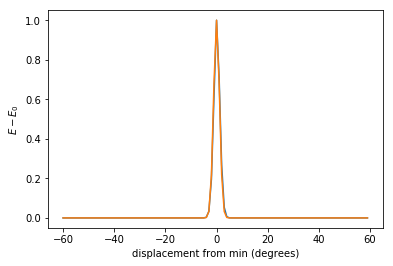

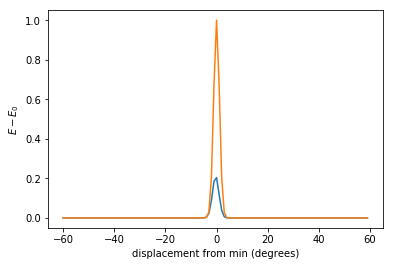

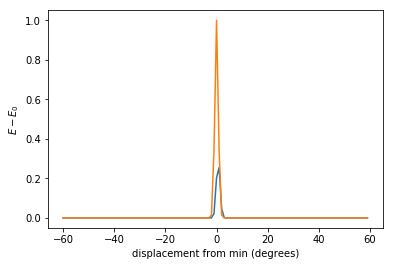

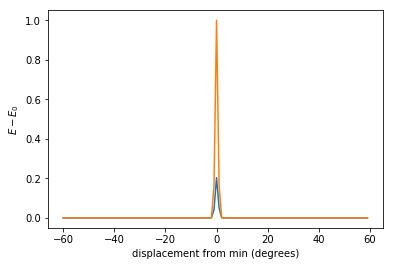

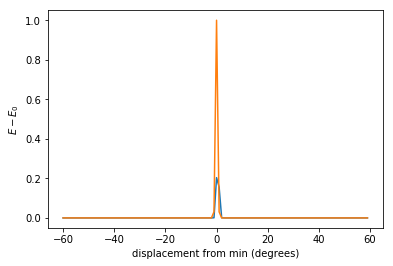

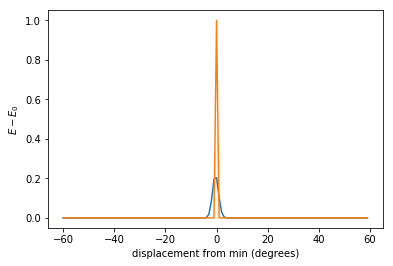

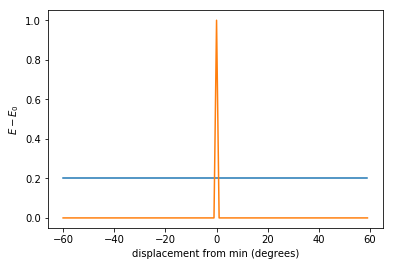

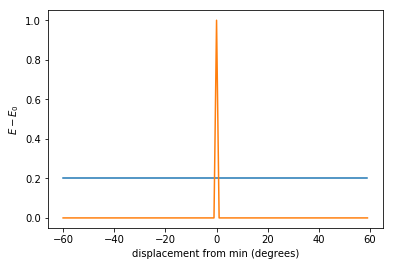

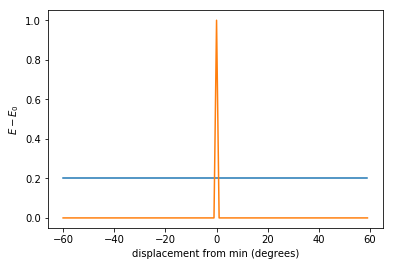

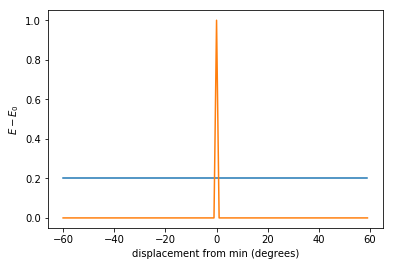

In [53]:
pose.assign(minimum)

for kk in range(20, 30):
    
        
    K = w[kk]
    
    if K < 0: continue 
    mode = v[:,kk]
    observer = AddPyMOLObserver(pose, True)
    h = np.arange(-60,60,1)
    h_plot = h*np.pi/180
    #h = np.concatenate((np.append(h, 15), h[: :-1]))

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            pose.set_torsion(dof_dict[jj], dof)

        bar.append(np.exp(-(scorefxn(pose)-E_0)))
        #print E_0, scorefxn(pose)

    np.array(bar) 
    pose.assign(trial)
    plt.figure()
    plt.plot(h, bar)
    plt.plot(h, np.exp(-0.5*K*h**2))
    plt.xlabel('displacement from min (degrees)')
    plt.ylabel('$E-E_0$')

In [54]:
from scipy.special import *

pose.assign(minimum)
Z_harm = 1
Z_scan = 1
for ii, kk in enumerate(w):
    
    K = kk
    
    if kk < 0: 
        
        continue 
    
    sig = min(2*np.pi/3, 6*np.sqrt(1.0/K))
    Z_i = np.sqrt(2.0*np.pi/K)*erf(np.sqrt(2.0*K)*sig/4.0)
    Z_j = mode_scan(pose, dofs, dof_dict, scorefxn, 1, v[:,ii], h = 1)
    Z_j *= np.pi/180
    Z_harm *= Z_i
    Z_scan *= Z_j
    pose.assign(minimum)
    print Z_i, Z_j

2.09425306953 2.08690776507
2.09372561105 2.0784593222
2.09265875326 2.07789550943
2.09225502235 2.07819535571
2.09117940521 2.07705161502
2.08915943219 2.07695648366
2.0874513215 2.07697820246
2.08715639611 2.07712250711
2.08480422066 2.07694909426
2.0815244118 2.07696157187
2.07413430457 2.07694237337
2.07100553803 2.07694180972
2.05838984334 2.07694180972
2.04544666852 2.07694180972
2.02710783991 2.07694180972
1.97778283173 2.07694180972
1.95625867479 2.07694180972
1.83601474871 2.07694180972
1.82785343647 2.07694180972
1.49750290802 2.07694180972
1.2546836823 2.07694180972
0.945322290664 2.07694180972
0.390025267519 2.07694180972
0.386462670446 2.09439510224
0.386455010114 2.09439510224
0.386455010114 2.09439510224
0.386455010114 2.09439510224
0.386455010114 2.09439510224


In [55]:
print -np.log(Z_harm)*0.61633, -np.log(Z_scan)*0.61633


-5.18551719266 -12.6432096543


In [56]:
def test_mode(x): return np.exp(-0.5*w[8]*180/np.pi*x**2)

In [ ]:
scipy.integrate.quad(test_mode, -np.pi/6, np.pi/6)